In [1]:
import laspy
import numpy as np
import os
from pathlib import Path
from pyproj import Geod  # high-precision geodesic calculations

# Define the folder path
folder_path = '/home/tavish/Documents/URC_Path_Finding/junk/candidates/'

# Initialize dictionary to store point clouds
point_clouds = {}

# Iterate through all .laz files in the folder

good = 0
bad = 0

for laz_file in Path(folder_path).glob('*.laz'):
    try:
        # Get file name without extension as ID
        file_id = laz_file.stem
        
        # Read the .laz file
        las = laspy.read(laz_file)
        
        # Extract XYZ coordinates as numpy array
        xyz = np.vstack((las.x, las.y, las.z)).T
        
        # Store in dictionary
        point_clouds[file_id] = xyz

        print(f"Loaded {file_id} with {xyz.shape[0]} points")
        good += 1
    except Exception as e:
        print(f"Failed to load {laz_file}: {e}")
        bad += 1


print(f"Loaded {len(point_clouds)} point clouds")
print(f"Good: {good}, Bad: {bad}")
print(f"IDs: {list(point_clouds.keys())}")

Loaded 12SWH1850 with 9741773 points
Loaded 12SWH2152 with 8095987 points
Loaded 12SWH2048 with 9903030 points
Loaded 12SWH1549 with 9991205 points
Loaded 12SWH1849 with 9769480 points
Loaded 12SWH1949 with 9831446 points
Loaded 12SWH2149 with 9179158 points
Loaded 12SWH1851 with 9803613 points
Loaded 12SWH1649 with 9749595 points
Loaded 12SWH1647 with 9965295 points
Loaded 12SWH1952 with 6407653 points
Loaded 12SWH1948 with 9731980 points
Loaded 12SWH1748 with 9701590 points
Loaded 12SWH1847 with 9765697 points
Loaded 12SWH2047 with 9228270 points
Loaded 12SWH2051 with 9926262 points
Loaded 12SWH1548 with 9395099 points
Loaded 12SWH1651 with 9990454 points
Loaded 12SWH2049 with 10103061 points
Loaded 12SWH1650 with 10205537 points
Loaded 12SWH2052 with 7218339 points
Loaded 12SWH2150 with 9602024 points
Loaded 12SWH1752 with 2959087 points
Loaded 12SWH1852 with 5084646 points
Loaded 12SWH1652 with 511758 points
Loaded 12SWH1751 with 9719564 points
Loaded 12SWH2151 with 9871261 points


In [2]:
import xml.etree.ElementTree as ET

def load_metadata(idx):

    # Define the directory path
    metadata_dir = "/home/tavish/Documents/URC_Path_Finding/junk/data/Projects/USGS_LPC_UT_Southern_QL1_2018_LAS_2019/metadata/"
    xml_file = f"USGS_LPC_UT_Southern_QL1_2018_{idx}_LAS_2019_meta.xml"

    # Load each XML file
    file_path = os.path.join(metadata_dir, xml_file)
    try:
        tree = ET.parse(file_path)
        xml_o = tree.getroot()
    except Exception as e:
        print(f"Error loading {xml_file}: {e}")
        return None, None, None, None
    
    west = np.float128(xml_o[0][4][0][0].text)
    east = np.float128(xml_o[0][4][0][1].text)
    north = np.float128(xml_o[0][4][0][2].text)
    south = np.float128(xml_o[0][4][0][3].text)

    return west, east, north, south

raw_data = {}

for idx in point_clouds.keys():
    west, east, north, south = load_metadata(idx)
    if west is None:
        continue
    raw_data[idx] = [west, east, north, south, point_clouds[idx]]

In [3]:
MDRS_ORIGIN = (-110.7919, 38.4065)  # (lon, lat)
geod = Geod(ellps="WGS84")

def latlon_to_local_xy(lat, lon, origin_lat=MDRS_ORIGIN[1], origin_lon=MDRS_ORIGIN[0]):
    az12, _, dist = geod.inv(origin_lon, origin_lat, lon, lat)
    theta = np.deg2rad(az12)
    x = dist * np.sin(theta)
    y = dist * np.cos(theta)
    return x, y

def distance_between_coords(lat1, lon1, lat2, lon2):
    _, _, dist = geod.inv(lon1, lat1, lon2, lat2)
    return dist

def latlon_pairs_to_xy(points, origin_lat=MDRS_ORIGIN[1], origin_lon=MDRS_ORIGIN[0]):
    results = []
    for lat, lon in points:
        results.append(latlon_to_local_xy(lat, lon, origin_lat=origin_lat, origin_lon=origin_lon))
    return np.array(results, dtype=np.float64)


In [4]:
# raw_data to cartesian coordinates

cartesian_data = {}

for idx in raw_data.keys():
    north_east = (*latlon_to_local_xy(raw_data[idx][2], raw_data[idx][1]),)
    south_west = (*latlon_to_local_xy(raw_data[idx][3], raw_data[idx][0]),)
    cartesian_data[idx] = [north_east, south_west, raw_data[idx][4]]

cartesian_data

{'12SWH1850': [(828.7740911871507, 61.334616220623126),
  (-169.27021517911692, -941.3875035125862),
  array([[5.18001090e+05, 4.25099922e+06, 1.39540000e+03],
         [5.18001180e+05, 4.25099884e+06, 1.39553000e+03],
         [5.18001250e+05, 4.25099848e+06, 1.39560000e+03],
         ...,
         [5.18999890e+05, 4.25002909e+06, 1.36622000e+03],
         [5.18999930e+05, 4.25002875e+06, 1.36619000e+03],
         [5.18999960e+05, 4.25002842e+06, 1.36616000e+03]])],
 '12SWH2152': [(3834.150550407657, 1931.7010641889908),
  (2836.4747917142886, 1052.253053855226),
  array([[5.21317460e+05, 4.25276955e+06, 1.40005000e+03],
         [5.21318230e+05, 4.25276965e+06, 1.40001000e+03],
         [5.21318280e+05, 4.25276957e+06, 1.40003000e+03],
         ...,
         [5.21999870e+05, 4.25202314e+06, 1.38095000e+03],
         [5.21999820e+05, 4.25202349e+06, 1.38112000e+03],
         [5.21999780e+05, 4.25202383e+06, 1.38112000e+03]])],
 '12SWH2048': [(2824.7984578165865, -1943.7182075642572),


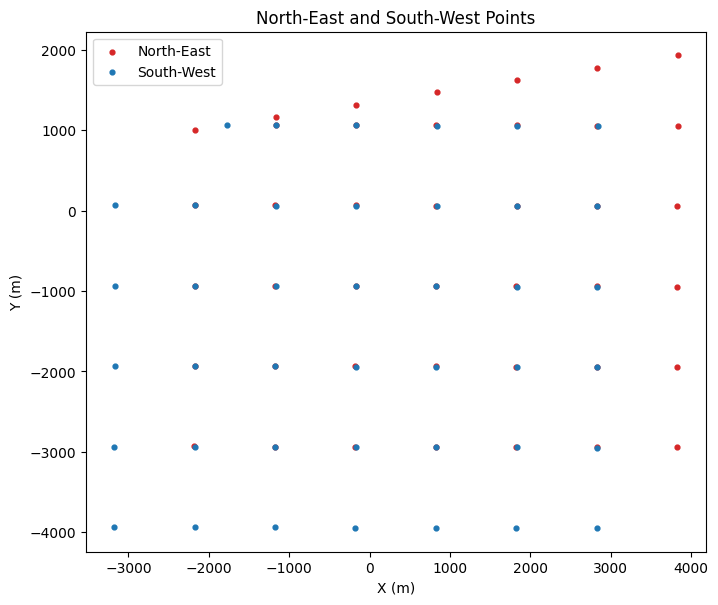

In [5]:
import matplotlib.pyplot as plt

north_east_points = np.array([vals[0] for vals in cartesian_data.values()])
south_west_points = np.array([vals[1] for vals in cartesian_data.values()])

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(north_east_points[:, 0], north_east_points[:, 1], s=12, c="tab:red", label="North-East")
ax.scatter(south_west_points[:, 0], south_west_points[:, 1], s=12, c="tab:blue", label="South-West")
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("North-East and South-West Points")
ax.legend()
plt.show()


In [6]:
# # Make one large map!

# global_map = []

# for idx in cartesian_data.keys():
#     ne = cartesian_data[idx][0]
#     sw = cartesian_data[idx][1]
#     points = cartesian_data[idx][2]
    
#     # Translate points to global coordinates
#     translated_points = points + np.array([sw[0], sw[1], 0])
    
#     global_map.append(translated_points)

# global_map = np.vstack(global_map)

In [ ]:
with

In [10]:
import matplotlib.pyplot as plt

x = cartesian_data["12SWH1547"][2][:, 0][::40]
y = cartesian_data["12SWH1547"][2][:, 1][::40]
z = cartesian_data["12SWH1547"][2][:, 2][::40]

plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=z, cmap='viridis', s=10)


KeyError: '12SWH1547'

In [8]:
# Persist cartesian tiles to disk and rebuild a memmapped global map to keep RAM low
import json
from numpy.lib.format import open_memmap

preprocessed_dir = Path("preprocessed")
preprocessed_dir.mkdir(parents=True, exist_ok=True)

tiles_index = {}
total_points = 0

for idx, (ne, sw, points) in cartesian_data.items():
    tile_path = preprocessed_dir / f"{idx}_cartesian.npy"
    np.save(tile_path, points.astype(np.float32), allow_pickle=False)
    tiles_index[idx] = {
        "south_west": [float(sw[0]), float(sw[1])],
        "north_east": [float(ne[0]), float(ne[1])],
        "points_file": tile_path.name,
        "point_count": int(points.shape[0])
    }
    total_points += points.shape[0]

with open(preprocessed_dir / "cartesian_index.json", "w", encoding="ascii") as fh:
    json.dump({"tiles": tiles_index, "total_points": total_points}, fh)

if "global_map" in locals():
    del global_map

global_map_mmap = open_memmap(
    preprocessed_dir / "global_map.npy", mode="w+", dtype=np.float32,
    shape=(total_points, 3)
 )

offset = 0
for idx, tile in tiles_index.items():
    pts = np.load(preprocessed_dir / tile["points_file"], mmap_mode="r")
    translated = pts #+ np.array([tile["south_west"][0], tile["south_west"][1], 0], dtype=np.float32)
    count = translated.shape[0]
    global_map_mmap[offset:offset + count] = translated
    offset += count

global_map_mmap.flush()
global_map = np.load(preprocessed_dir / "global_map.npy", mmap_mode="r")
del global_map_mmap

for cache_name in ("cartesian_data", "point_clouds", "raw_data"):
    if cache_name in locals():
        locals()[cache_name].clear()

import gc
gc.collect()

517

In [9]:
cartesian_data

{}